# Homework 1 - Name, SCIPER

In this homework, we're going to build a neural network without using deep learning packages.

Specifically, we're going to build a neural network that annotate cells to cell types in the Pancreas tissue. To do so, we'll need a few building blocks:
- Fully-connected layer, $f(X)=X \cdot W + \vec{b}$
- Nonlinearity layer (ReLU in this homework)
- Loss function (Cross-entropy in this homework)
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Reference: 
- https://github.com/yandexdataschool/Practical_DL/tree/fall23
- https://github.com/theislab/scarches-reproducibility

In [1]:
import numpy as np
np.random.seed(0)

## 0. Create the Parent Class 'Layer' (0 pt)

As we learned in the lecture, we need layers that can do both forward pass and backward pass. Here we define the parent class of all layers.

In [2]:
class Layer:

    """
    Each layer performs two things:
    1. Forward pass: Process input to get output: output = layer.forward(input)
    2. Backward pass: Back-propagate gradients through itself: grad_input = layer.backward(input, grad_output)

    The layers that contain learnable parameters also update their parameters during layer.backward.
    """

    def __init__(self):
        """
        Initialize layer parameters.
        """

        # Here we use a dummy layer that does nothing.
        pass

    def forward(self, input):
        """
        Takes input data of shape [batch, input_dims], returns output data [batch, output_dims]
        """

        # Here we use a dummy layer that returns the input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer.

        We need to apply the chain rule to compute the gradients of the input x:
        d loss / d x  = (d loss / d layer) * (d layer / d x)

        Grad_output provides us d loss / d layer, so we only need to multiply it by d layer / d x.

        Note that if the layer has trainable parameters, we also need to update them using d loss / d layer.
        """

        # The gradient of a dummy layer is grad_output
        return grad_output

## 1. Build layers

We will shortly introduce our dataset's structure in this section, and it should be enough to complete the functions in this section. However, if you find knowing the dataset structure is super helpful to implement the functions of this section, *you can jump to Section 2* and check the dataset structure before going through this section.

### 1.1. Nonlinearity layer - ReLU (1 pt) 

We start from the simplest layer: nonlinearity layer. It simply applies a nonlinearity to each element of your network and it contains no trainable parameter.

Here we implement ReLU. 

Check this link to review ReLU if needed: https://www.v7labs.com/blog/neural-networks-activation-functions

In [3]:
class ReLU(Layer):
    def __init__(self):
        """
        ReLU layer applies elementwise rectified linear to the elements in the inputs.
        There is nothing to initialize in this simple implementation.
        """

        pass

    def forward(self, input):
        """
        Apply elementwise ReLU to the input
        """
        output = np.maximum(0, input)
        
        return output

    def backward(self, input, grad_output):
        """
        Compute the gradient of loss. 
        """
        derivative = 1 * (input > 0) # 1 * (input > 0) is the derivative of ReLU following piece-wise differentiation
        grad_input = derivative * grad_output   # apply chain rule to get the gradient of the output with respect to input

        return grad_input

### 1.2. Fully-connected Layer (2 pts)

After implementing the simplest layer, we come to a more complicated one: a fully-connected layer. Unlike a nonlinearity layer, a fully-connected layer has trainable parameters.

A fully-connected layer applies an affine transformation. It can be described as: 
$$f(X)= X \cdot W + \vec b ,$$

where
* X is the input of shape [batch_size, input_dims],
* W is a weight matrix [input_dims, output_dims],
* and b is a vector of outputs_dims biases.

W and b are
* initialized when the layer is created,
* and updated each time backward is called.

In [4]:
class Fully_connected(Layer):
    def __init__(self, input_dims, output_dims, learning_rate=0.01):
        """
        Fully_connected layer: f(x) = <x*W> + b
        We initialize W, b, and learning rate to update W and b.
        """

        # ToDo: Here we use normal initialization for W and zero initialization for b
        # Hint: Scale the weights initialization. Think about whether to scale them to large or small.

        # self.weights = np.random.randn(input_dims, output_dims)
        k = 1 / input_dims
        sqrt_k = np.sqrt(k)
        self.weights = np.random.uniform(-sqrt_k, sqrt_k, size=(input_dims, output_dims))
        self.biases = np.random.uniform(-sqrt_k, sqrt_k, size=(output_dims))

        self.learning_rate = learning_rate

    def forward(self,input):
        """
        Perform f(x) = <x*W> + b .

        input shape: [batch, input_dims]
        output shape: [batch, output_dims]
        """

        output = input @ self.weights + self.biases

        return output

    def backward(self,input,grad_output):

        # ToDo: calculate the grad_input to back propagate

        dx = grad_output @ self.weights.T
        dw = input.T @ grad_output
        db = grad_output.sum(0)

        grad_input = dx

        # Here we perform a stochastic gradient descent (SGD) step: x = x - learning_rate * gradient_of_x.
        # ToDo: Update parameter W
        self.weights -= self.learning_rate * dw

        # ToDo: Update parameter b
        
        self.biases -= self.learning_rate * db

        return grad_input

### 1.3. The loss function - softmax cross-entropy (2 pts)

Our model outputs the logits. Since we want to predict probabilities, it would be logical for us to apply softmax nonlinearity to our output logits and compute loss with predicted probabilities.

If you are not familiar with softmax or cross-entropy loss, you can check:
- Softmax: https://en.wikipedia.org/wiki/Softmax_function
- Cross-entropy loss: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy


(We encourage you to first write down the expression for cross-entropy as a function of softmax logits. You can then try to rewrite it into a more concise form.)

In [5]:
def softmax(x):
    """
    Compute softmax values for each sets of scores in x with shape [batch,n_classes].
    """
    ex = np.exp(x)
    return ex / np.sum(ex, 1, keepdims=1) # standard: np.exp(x) / np.sum(np.exp(x), 1)

def softmax_crossentropy_with_logits(logits,reference_answers):
    """
    Compute cross-entropy loss for each sample from output logits [batch,n_classes] and reference_answers [batch].
    Note that the reference_answers are not one-hot labels. Instead, they are the index of the categories, e.g., 2 instead of [0,0,1].
    The output (xentropy) shape should be [batch,1] or [batch].
    """
    n = len(reference_answers)

    # compute probabilities using softmax (output shape: [batch,n_classes])
    softmaxed_logits = softmax(logits)

    # extract probabilities of the correct answers only (output shape: [batch])
    predicted_probs = softmaxed_logits[range(n), reference_answers]

    # compute cross entropy as negative sum of log-probabilities of the correct answers
    xentropy = -np.mean(np.log(predicted_probs))

    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """
    Compute cross-entropy gradient from output logits [batch,n_classes] and reference_answers [batch].
    Note that the reference_answers are not one-hot labels. Instead, they are the index of the categories, e.g., 2 instead of [0,0,1].
    """

    # ToDo: Get the cross-entropy gradient based on output logits and reference_answers
    # Hint: Same as before, it is better to first derive and get the simplest form of the softmax cross-entropy gradient before implementation.

    """
    # vectorised implementation of softmax (output shape: [batch,n_classes])
    softmaxed_logits = softmax(logits)

    predicted_probs = softmaxed_logits[np.arange(len(logits)), reference_answers]

    # gradient is 0 for all classes except the correct one, for which it is -1 / p_j
    grad_input = np.zeros(softmaxed_logits.shape)
    grad_input[np.arange(len(logits)), reference_answers] = -1 / predicted_probs
    """
    n = len(reference_answers)
    grad_input = softmax(logits)
    grad_input[np.arange(n), reference_answers] -= 1
    grad_input /= n
    
    return grad_input

### 1.4. Network and Forward pass (1 pts)

First, we define network as a list of layers, each applied on top of previous one.

In [6]:
network = []
network.append(Fully_connected(1000, 256))
network.append(ReLU())
network.append(Fully_connected(256, 64))
network.append(ReLU())
network.append(Fully_connected(64, 8))

Here, we implement the forward pass.

In [7]:
def forward(network, X):
    """
    Compute the output of all network layers by applying them sequentially.
    Note that we should return a list of outputs for each layer since we need them for backward pass.
    """
    
    outputs = []
    input = X

    for layer in network:
        output = layer.forward(input)
        outputs.append(output)
        input = output

    return outputs

def predict(network, X):
    """
    Use network to predict the result for each sample. Since we are doing classification, the result should be the index of the most likely class.
    """

    # ToDo: using network to get the final output of the model
    prediction = np.argmax(forward(network, X)[-1], axis=1)

    return prediction

### 1.5. Train and Backprop (2 pts)

We implement the training function here. The function takes a network, network input X, and ground truth y as the inputs.
When calling this function, we want to have a forward pass and a backward pass.

In [8]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y only once.
    Here are the steps to train once:
    1. Run forward to get all layer outputs.
    2. Estimate loss and loss_grad.
    3. Run layer.backward going from last layer to first.

    Note that after you called backward for all layers, the layers with trainable parameters should have already updated.
    """

    # ToDo: run forward to get outputs of all layers.
    layer_outputs = forward(network, X)

    # ToDo: Since we need the layer input for backward pass, here we get a list of layer input. 
    # Hint: layer_input[i] is an input for network[i].
    layer_inputs = [X, *layer_outputs[:-1]]
    logits = layer_outputs[-1]

    # ToDo: Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits, y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits, y)

    # ToDo: propagate gradients through network layers using .backward
    # Hint: start from last layer and move to earlier layers
    for layer in network[::-1]:
        layer_input = layer_inputs.pop()
        loss_grad = layer.backward(layer_input, loss_grad)

    return np.mean(loss)

## 2. Test your network (2 pt)

In this homework, we use a single-cell dataset: Pancreas Dataset. Our task is to classify cells to cell types based on the gene expression information. There are 8 different cell types. Cells are samples, genes are features, and cell types are classes.

You need to load the data from '.csv' and implement a simple dataloader. (If you do not remember why we need a dataloader, you can check Exercise 1.)

In [9]:
# ToDo: Load input data from 'data.csv'. Data in csv has 8391 rows and 1000 columns

# 8391 rows mean there are 8391 cells.
# 1000 columns mean 1000 genes are measured for each cell.

# ToDo: Load labels from 'label.csv' using numpy. Do not import other packages, e.g., pandas.
data = np.loadtxt('data.csv', delimiter=',')

# There are 8391 strings in 'label.csv', and they are the cell type of the 8391 cells.
# The input data and labels are aligned:
# For example, the first string in 'label.csv' is the cell type of the first cell (frist row of data) of 'data.csv'
# In other words, data[0] and cell_type_per_sample[0] should be paired.

cell_type_per_sample = np.loadtxt('label.csv', delimiter=",", dtype=str)

# ToDo: Get integer labels from the cell types of data type string
uniques = np.unique(cell_type_per_sample)
idx2label = {idx: label for idx, label in enumerate(uniques)}
label2idx = {label: idx for idx, label in enumerate(uniques)}

labels = np.array([label2idx[cell_type] for cell_type in cell_type_per_sample])

# ToDo: Split train and val data. You can choose the ratio of splitting, and you can decide whether to shuffle the data or not.
n, p = data.shape
train_ratio = 0.8
train_samples = int(n * train_ratio)

X_train = data[:train_samples]
y_train = labels[:train_samples]

X_val = data[train_samples:]
y_val = labels[train_samples:]

Now, we have the training and test data. We need a dataloader.

In [10]:
# A mini-dataloader
from tqdm import trange

# Note: function signatures should remain the same, but the skeleton is just a guide and can be changed.
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)

    indices = np.arange(len(inputs))
    if shuffle:
        # ToDo: re-order the indices for shuffling the samples
        np.random.shuffle(indices)
    
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):

        # ToDo: get indexs for the current mini-batch
        indexs = np.arange(start_idx, start_idx + batchsize)
        indexs = indices[indexs]

        yield inputs[indexs], targets[indexs]

Now, test your model! You should get a more than 90% accuracy for training data and a more than 85% accuracy for validation data.

Epoch 9
Train accuracy: 0.9149284862932062
Val accuracy: 0.8921977367480644


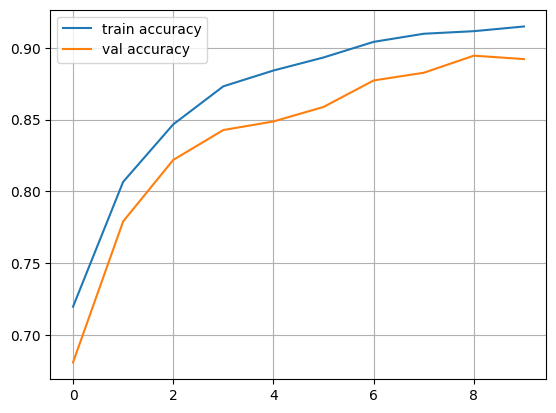

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

train_log = []
val_log = []

for epoch in range(10):
    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=256, shuffle=True):
        train(network, x_batch, y_batch)

    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))

    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])

plt.plot(train_log,label='train accuracy')
plt.plot(val_log,label='val accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()